In [55]:
import torch#
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt 
import sys
import time
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

import os
import platform
from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'


In [56]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
print(f'Using device: {device}')


Using device: cpu


In [57]:
home_directory = os.path.expanduser('~')
system_type = platform.system()

# デフォルトの OneDrive フォルダ名
onedrive_path = None
if system_type == "Windows":
    # Windows では環境変数が使える（MS公式な方法）
    onedrive_path = os.environ.get("OneDrive")
    if onedrive_path is None:
        # フォールバック
        onedrive_path = os.path.join(home_directory, "OneDrive")
elif system_type == "Darwin": 
    onedrive_path = os.path.join(home_directory, "Library", "CloudStorage", "OneDrive-個人用(2)")

print(f"OneDrive path: {onedrive_path}")


OneDrive path: /Users/konishi/Library/CloudStorage/OneDrive-個人用(2)


In [58]:
# CSVファイルの読み込み
file_path =os.path.join(onedrive_path,'CODES','samples','covtype.csv')
data = pd.read_csv(file_path)

# データの前処理
data = data.dropna()  # 欠損値を削除

# 特徴量とターゲットに分ける
# 'Engine Condition' をターゲット変数として仮定
X = data.drop(columns=['Cover_Type'])
y_origin = data['Cover_Type']-1

# 特徴量を標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)#平均と標準偏差を使ってデータをスケーリング


In [59]:
def get_new_dataloader(X_scaled, y_origin, test_size=0.2, batch_size=512):
    # ランダムに分割（シャッフル付き）
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_origin, test_size=test_size, shuffle=True
    )

    # Tensor変換
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)   # ここだけで十分

    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)   # ここだけで十分


    # DataLoader 作成
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [60]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)

        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)

        self.fc3 = nn.Linear(128, 7)

    def forward(self, x):
        x = self.fc1(x) 
        x = self.bn1(x)     
        x = F.relu(x)           
        #x = self.drop1(x)         

        x = self.fc2(x) 
        x = self.bn2(x)      
        x = F.relu(x) 
        #x = self.drop2(x) 

        x = self.fc3(x)   
        return x     


In [61]:
class EncoderClassifier(nn.Module):
    def __init__(self,input_dim, leverage):
        super(EncoderClassifier, self).__init__()
        potential_dim = int(input_dim//leverage)
        self.classifier =  MLP(potential_dim)
        
    def forward(self, x):
        x = self.classifier(x)
        return x

54


1/2th Time Epoch: 50/50

Test Accuracy: 90.13%
loss_train: 0.8152,loss_test: 0.8275
LOSS:0.8275
ProcessingTime: 176.09711718559265


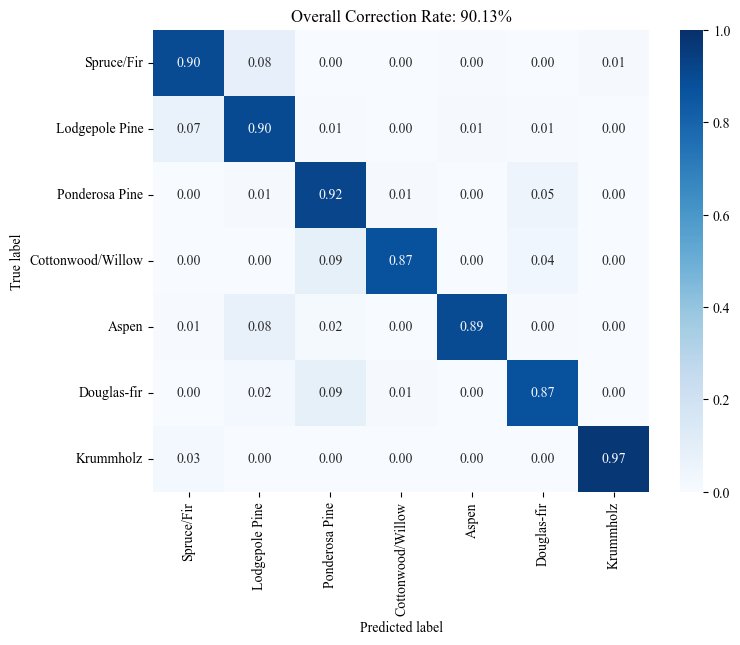

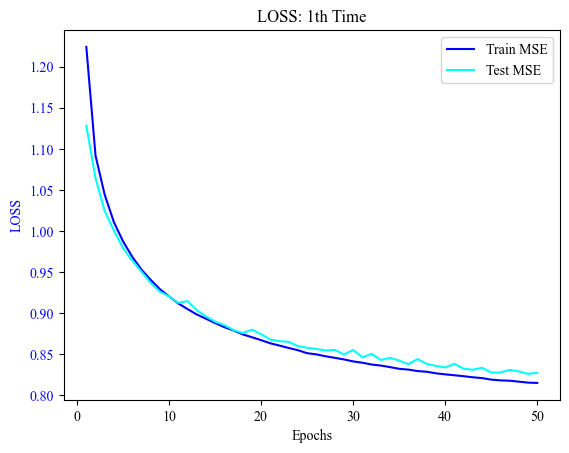

2/2th Time Epoch: 50/50

Test Accuracy: 90.25%
loss_train: 0.8130,loss_test: 0.8219
LOSS:0.8219
ProcessingTime: 169.8281593322754


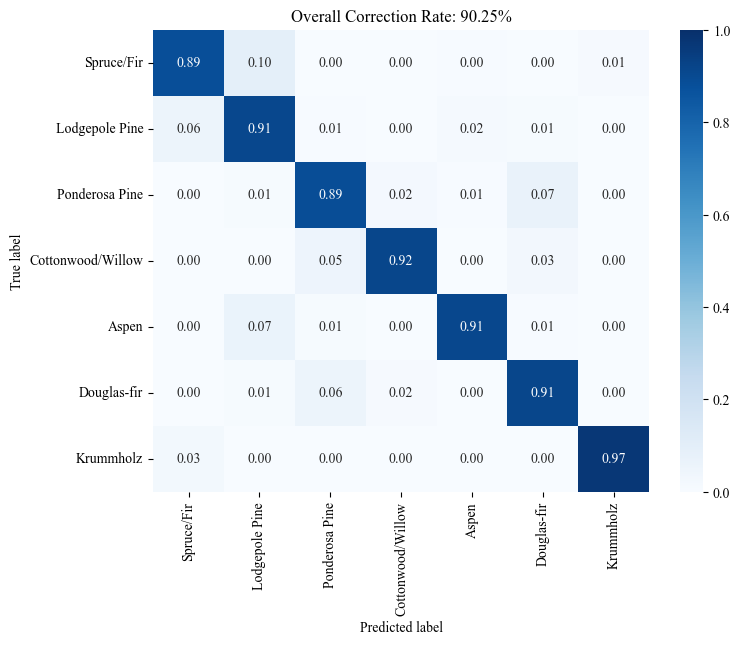

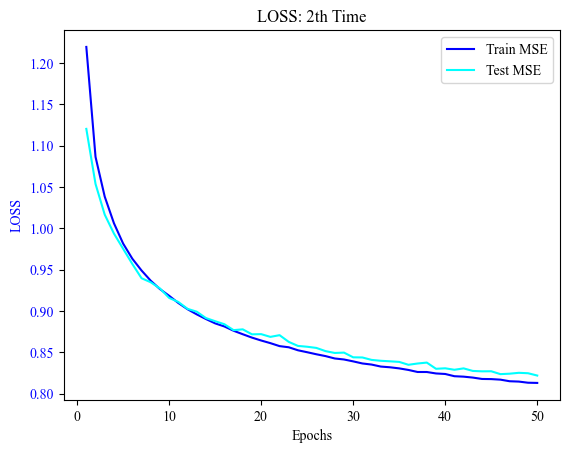

In [62]:
input_dim = X_scaled.shape[1]
print(input_dim)
leverage = 1  # 圧縮倍率
max_epochs = 50
lr = 3e-4 #学習率

num_try = 2 #

All_last_loss = []
All_loss_test = []
All_pro_time = []
All_test_acc = []

for num_times in range(num_try): 
    train_dataloader, test_dataloader = get_new_dataloader(X_scaled,y_origin)
    model = EncoderClassifier(input_dim,leverage).to(device)
    counts = np.bincount(y_origin)
    class_w = torch.tensor(1.0 / np.sqrt(counts), dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_w, label_smoothing=0.05)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_train_ = []
    loss_test_ = []
    pro_time_ = []

    for epoch in range(max_epochs):
        model.train()
        sys.stderr.write('\r%d/%dth Time Epoch: %d/%d' % (num_times+1,num_try, epoch+1, max_epochs)) 
        sys.stderr.flush()
        
        loss_train = 0
        loss_test = 0

        start_time1 = time.time()
        for batch_X, batch_Y in train_dataloader:
            batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_Y)
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        loss_train_avg = loss_train / len(train_dataloader)
        end_time1 = time.time()
        pro_time_.append(end_time1-start_time1)


        with torch.no_grad():
            all_preds = []
            all_labels = []
            correct = 0
            total = 0
            for x, t in test_dataloader:
                x, t = x.to(device), t.to(device)
                y = model(x).to(device)
                _, predicted = torch.max(y, 1)
                loss = criterion(y,t)
                loss_test += loss.item()        
                total += t.size(0)
                correct += (predicted == t).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(t.cpu().numpy())

        loss_test_avg = loss_test / len(test_dataloader)

        loss_train_.append(loss_train_avg)
        loss_test_.append(loss_test_avg)
        #if epoch == max_epochs-1:
    All_loss_test.append(loss_test_)
    All_pro_time.append(sum(pro_time_)) 

    cm = confusion_matrix(all_labels, all_preds)
    cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)  # 正規化（行ごとに割合に）

    Last_loss_test = loss_test_[-1]
    All_last_loss.append(Last_loss_test)
    All_test_acc.append(100 * correct / total)
    print(f"Test Accuracy: {100 * correct / total:.2f}%")
    print(f"loss_train: {loss_train_avg:.4f},loss_test: {loss_test_avg:.4f}")
    print(f"LOSS:{Last_loss_test:.4f}")
    print('ProcessingTime:',sum(pro_time_))

    labels = [
        "Spruce/Fir",        # 0
        "Lodgepole Pine",    # 1
        "Ponderosa Pine",    # 2
        "Cottonwood/Willow", # 3
        "Aspen",             # 4
        "Douglas-fir",       # 5
        "Krummholz"          # 6
    ]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
                 xticklabels=labels, yticklabels=labels,
                 vmin=0.0, vmax=1.0)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(f"Overall Correction Rate: {100 * correct / total:.2f}%")
    plt.show()

    fig, ax1 = plt.subplots()
    ax1.plot(range(1,len(loss_train_)+1), loss_train_, label="Train MSE", color = 'blue')
    ax1.plot(range(1,len(loss_test_)+1), loss_test_, label="Test MSE", color = 'cyan')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('LOSS', color = 'blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.legend()

    title = 'LOSS: %dth Time'%(num_times+1) #
    plt.title(title)
    plt.show()


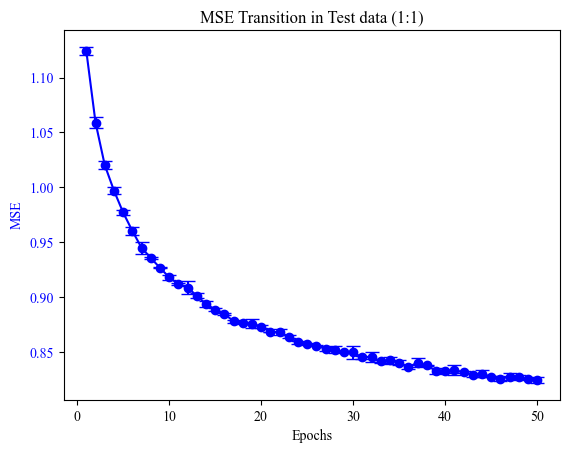

In [63]:
epochs = len(All_loss_test[0])  # エポック数（各リストの長さ）
num_dimensions = len(All_loss_test)  # 埋め込み次元数の数

# 各エポックごとに平均と標準偏差を計算
mean_loss = np.mean(All_loss_test, axis=0)
std_loss = np.std(All_loss_test, axis=0)

# グラフの描画
fig, ax1 = plt.subplots()

# 平均値の折れ線グラフと誤差範囲（標準偏差の誤差棒）
ax1.errorbar(
    x=range(1, epochs + 1), y=mean_loss, yerr=std_loss,
    fmt='-o', color='blue', ecolor='blue', capsize=5, 
)

# 軸ラベルやタイトルの設定
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
plt.title('MSE Transition in Test data (1:%d)' % leverage)


plt.show()

In [64]:
import csv
ACC_mean = np.mean(All_test_acc)
ACC_best = np.max(All_test_acc)
ACC_bestID = np.argmax(All_test_acc)+1
ACC_worst = np.min(All_test_acc)
ACC_worstID = np.argmin(All_test_acc)+1

LOSS_mean = np.mean(All_last_loss)
LOSS_best = np.min(All_last_loss)
LOSS_bestID = np.argmin(All_last_loss)+1
LOSS_worst = np.max(All_last_loss)
LOSS_worstID = np.argmax(All_last_loss)+1

data = {
        "": ["ACC", "LOSS"],
    "Average": [ACC_mean, LOSS_mean],
    "Best ID": [ACC_bestID, LOSS_bestID],
    "Best": [ACC_best, LOSS_best],
    "Worst ID": [ACC_worstID, LOSS_worstID],
    "Worst": [ACC_worst, LOSS_worst],
}

df = pd.DataFrame(data)

print(df)


           Average  Best ID       Best  Worst ID      Worst
0   ACC  90.190012        2  90.251543         1  90.128482
1  LOSS   0.824717        2   0.821925         1   0.827508


In [65]:
import csv
save_directory1 = os.path.join(onedrive_path,'CODES', 'konishi_Classifer', 'data','Cover_texts') 
print(save_directory1)
os.makedirs(save_directory1, exist_ok=True)
file_name = 'MLP_Class00_list.csv'##
full_path = os.path.join(save_directory1, file_name)
with open(full_path, mode='w', newline='') as file:
    writer = csv.writer(file)

    writer.writerow(All_loss_test)

/Users/konishi/Library/CloudStorage/OneDrive-個人用(2)/CODES/konishi_Classifer/data/Cover_texts
